In [8]:
import sys
sys.path.append("../..")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from surgeNN import io
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import os

In [9]:
#configure the script
tgs        = ['esbjerg-esb-dnk-dmi.csv']
tgnames = ['Esbjerg (DK)']

qnts = np.array([.95,.98,.99,.995]) #quantiles, don't touch

max_timesteps_between_extremes=3

Load data-driven predictions:

In [16]:
#load the predictions
lstms = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns/performance_modified/lstm')
lstms.open_performance_data(tgs)
lstms.data = lstms.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

convlstms = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns/performance_modified/convlstm')
convlstms.open_performance_data(tgs)
convlstms = convlstms.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

#compute metrics for observations (it,i doesn't matter as long as all models have been run with the same n_t)
observed_thresholds = lstms.observed_thresholds()
observed_stds = lstms.observed_stds()

lstms = lstms.data

lstms_1p5 = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns/performance_modified/lstm_1p5')
lstms_1p5.open_performance_data(tgs)
lstms_1p5 = lstms_1p5.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

convlstms_1p5 = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns/performance_modified/convlstm_1p5')
convlstms_1p5.open_performance_data(tgs)
convlstms_1p5 = convlstms_1p5.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

Plot performance of 5 degree and 1p5 degree predictor region trained models at Esbjerg:

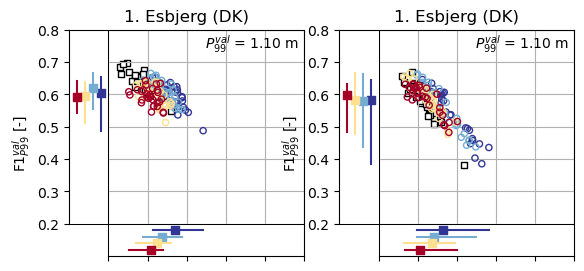

In [18]:
#configure the plot
store_fig = 0 #flag to save output

out_split = 'test' #split to plot
out_q = .99 #quantile to plot

nn_marker_size=40 
threshold_color = 'black' #colorbars for errors relative to p99

alpha_cmap = plt.get_cmap('RdYlBu_r', 6) #alpha colormap

#make the figure 
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.15)
gs.update(hspace=.2)


lowest_rmses_a0 = [] #to store some statistics
lowest_rmses_a5 = []
highest_f1_a0 = []
highest_f1_aHt0 = [] #alpha higher than 0

for t,tg in enumerate(tgs): #loop over locations
    ax = plt.subplot(gs[np.unravel_index(t,(3,3))]) #(a) RMSEs

    #plot fraction of 99th percentile as background color and annotate
    ax.grid(zorder=0)
    ax.text(.78,.92,'$P_{99}^{val}$ = '+"{:.2f}".format(observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values) + ' m',alpha=1,color=threshold_color,ha='center',transform=ax.transAxes)
    
    #plot performance values for each alpha and model
    for ia,a in enumerate(np.array([0,1,3,5])): 
        #plot LSTMs:
        #add label once, for first tg
        relrmses = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values
        f1s = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()
        sc = ax.scatter(relrmses,
                        f1s,
            facecolor='None',edgecolor=alpha_cmap(a),label='LSTM model ('+'$ \\alpha $'+'='+str(a)+')',s=20,zorder=1)
        
        conv_relrmses = convlstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values
        conv_f1s = convlstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()
        sc = ax.scatter(conv_relrmses,
                        conv_f1s,
            facecolor='white',edgecolor='black',label='ConvLSTM model ('+'$ \\alpha $'+'='+str(a)+')',marker='s',s=20,zorder=0)
        
        ax.plot([.18-ia*.02,.18-ia*0.02],[np.nanmin(f1s),np.nanmax(f1s)],color=alpha_cmap(a),zorder=3)
        ax.scatter([.18-ia*.02],[np.nanmedian(f1s)],c=[alpha_cmap(a)],marker='s',zorder=3)
        
        ax.plot([np.nanmin(relrmses),np.nanmax(relrmses)],[.18-ia*.02,.18-ia*.02],color=alpha_cmap(a),zorder=5)
        ax.scatter([np.nanmedian(relrmses)],[.18-ia*.02],c=[alpha_cmap(a)],marker='s',zorder=5)
        
    rec = matplotlib.patches.Rectangle((.1,.1-.1),.1,.7+.1,color='white',zorder=2)
    ax.add_patch(rec)

    rec1 = matplotlib.patches.Rectangle((.1,.1),.7,.1,color='white',zorder=4)
    ax.add_patch(rec1)
        
    ax.axhline(y=.2,color='black',linewidth=.75,zorder=6)
    ax.axvline(x=.2,color='black',linewidth=.75,zorder=6)
        
    ax.set_ylim([.1,.8])
    ax.set_xlim([.1,.7])
    
    ax.set_xticks([.2,.3,.4,.5,.6,.7])
    ax.set_yticks([.2,.3,.4,.5,.6,.7,.8])
    if np.mod(t,3)==0:
        ax.set_ylabel('F1$_{P99}^{val}$ [-]')
    else:
        ax.set_yticklabels([])

    if t>5:
        ax.set_xlabel(r'$\frac{{1}}{{P_{99}^{val}}} \times RMSE_{P99}^{val}$ [-]')
        
    else:
        ax.set_xticklabels([])
    ax.set_axisbelow(True)
    
    if t==4:
        ax.legend(bbox_to_anchor=(.17, .15))

    ax.set_title(str(t+1)+'. '+tgnames[t])
    
    ax.spines['left'].set_bounds(.2, .8)
    ax.spines['bottom'].set_bounds(.2, .7)
    for k, spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)

        
        
for t,tg in enumerate(tgs): #loop over locations
    ax = plt.subplot(gs[0,1]) #(a) RMSEs

    #plot fraction of 99th percentile as background color and annotate
    ax.grid(zorder=0)
    ax.text(.78,.92,'$P_{99}^{val}$ = '+"{:.2f}".format(observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values) + ' m',alpha=1,color=threshold_color,ha='center',transform=ax.transAxes)
    
    #plot performance values for each alpha and model
    for ia,a in enumerate(np.array([0,1,3,5])): 
        #plot Lstms_1p5:
        #add label once, for first tg
        relrmses = lstms_1p5.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(lstms_1p5.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values
        f1s = lstms_1p5.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(lstms_1p5.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()
        sc = ax.scatter(relrmses,
                        f1s,
            facecolor='None',edgecolor=alpha_cmap(a),label='LSTM model ('+'$ \\alpha $'+'='+str(a)+')',s=20,zorder=1)
        
        conv_relrmses = convlstms_1p5.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(convlstms_1p5.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values
        conv_f1s = convlstms_1p5.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(convlstms_1p5.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()
        sc = ax.scatter(conv_relrmses,
                        conv_f1s,
            facecolor='white',edgecolor='black',label='ConvLSTM model ('+'$ \\alpha $'+'='+str(a)+')',marker='s',s=20,zorder=0)
        
        ax.plot([.18-ia*.02,.18-ia*0.02],[np.nanmin(f1s),np.nanmax(f1s)],color=alpha_cmap(a),zorder=3)
        ax.scatter([.18-ia*.02],[np.nanmedian(f1s)],c=[alpha_cmap(a)],marker='s',zorder=3)
        
        ax.plot([np.nanmin(relrmses),np.nanmax(relrmses)],[.18-ia*.02,.18-ia*.02],color=alpha_cmap(a),zorder=5)
        ax.scatter([np.nanmedian(relrmses)],[.18-ia*.02],c=[alpha_cmap(a)],marker='s',zorder=5)
        
    rec = matplotlib.patches.Rectangle((.1,.1-.1),.1,.7+.1,color='white',zorder=2)
    ax.add_patch(rec)

    rec1 = matplotlib.patches.Rectangle((.1,.1),.7,.1,color='white',zorder=4)
    ax.add_patch(rec1)
        
    ax.axhline(y=.2,color='black',linewidth=.75,zorder=6)
    ax.axvline(x=.2,color='black',linewidth=.75,zorder=6)
        
    ax.set_ylim([.1,.8])
    ax.set_xlim([.1,.7])
    
    ax.set_xticks([.2,.3,.4,.5,.6,.7])
    ax.set_yticks([.2,.3,.4,.5,.6,.7,.8])
    if np.mod(t,3)==0:
        ax.set_ylabel('F1$_{P99}^{val}$ [-]')
    else:
        ax.set_yticklabels([])

    if t>5:
        ax.set_xlabel(r'$\frac{{1}}{{P_{99}^{val}}} \times RMSE_{P99}^{val}$ [-]')
        
    else:
        ax.set_xticklabels([])
    ax.set_axisbelow(True)
    
    if t==4:
        ax.legend(bbox_to_anchor=(.17, .15))

    ax.set_title(str(t+1)+'. '+tgnames[t])
    
    ax.spines['left'].set_bounds(.2, .8)
    ax.spines['bottom'].set_bounds(.2, .7)
    for k, spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)
